In [1]:
# Cell 1: Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import signal
from scipy.fft import fft, fftfreq
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
import warnings
warnings.filterwarnings('ignore')

print("All libraries imported successfully")
print(f"TensorFlow version: {tf.__version__}")

All libraries imported successfully
TensorFlow version: 2.17.1


In [2]:
# Cell 2: Load and combine all datasets
# Assuming you have CSV files named: motorOFF.csv, motorON.csv, motorON_NoFan.csv, motorON_BadFan.csv
file_paths = {
    'motorOFF': 'datasets/train/motorOFF.csv',
    'motorON': 'datasets/train/motorON.csv', 
    'motorON_NoFan': 'datasets/train/motorON_NoFan.csv',
    'motorON_BadFan': 'datasets/train/motorON_BadFan.csv'
}

dataframes = []
for label_name, file_path in file_paths.items():
    df = pd.read_csv(file_path)
    df['original_label'] = label_name
    dataframes.append(df)

# Combine all data
full_data = pd.concat(dataframes, ignore_index=True)
print(f"Total samples: {len(full_data)}")
print(f"Data shape: {full_data.shape}")
print("\nLabel distribution:")
print(full_data['original_label'].value_counts())

Total samples: 480000
Data shape: (480000, 5)

Label distribution:
original_label
motorOFF          120000
motorON           120000
motorON_NoFan     120000
motorON_BadFan    120000
Name: count, dtype: int64


In [3]:
# Cell 3: Basic EDA and data overview
print("Basic Data Information:")
print(full_data.info())
print("\nFirst 5 rows:")
print(full_data.head())

print("\nStatistical Summary:")
print(full_data[['ax', 'ay', 'az']].describe())

# Check for missing values
print("\nMissing values:")
print(full_data.isnull().sum())

Basic Data Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 480000 entries, 0 to 479999
Data columns (total 5 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   ax              480000 non-null  float64
 1   ay              480000 non-null  float64
 2   az              480000 non-null  float64
 3   label           480000 non-null  int64  
 4   original_label  480000 non-null  object 
dtypes: float64(3), int64(1), object(1)
memory usage: 18.3+ MB
None

First 5 rows:
         ax        ay        az  label original_label
0 -2.338984 -9.701700  0.086142      0       motorOFF
1 -2.379662 -9.632308  0.072981      0       motorOFF
2 -2.378466 -9.665807  0.050249      0       motorOFF
3 -2.371287 -9.702895  0.080160      0       motorOFF
4 -2.415555 -9.693325  0.065803      0       motorOFF

Statistical Summary:
                  ax             ay             az
count  480000.000000  480000.000000  480000.000000
mean       -0

In [4]:
# Cell 4: Calculate additional features - Acceleration Vector Magnitude
full_data['av'] = np.sqrt(full_data['ax']**2 + full_data['ay']**2 + full_data['az']**2)
print("Acceleration vector magnitude calculated")
print(full_data[['ax', 'ay', 'az', 'av']].head())

Acceleration vector magnitude calculated
         ax        ay        az        av
0 -2.338984 -9.701700  0.086142  9.980043
1 -2.379662 -9.632308  0.072981  9.922171
2 -2.378466 -9.665807  0.050249  9.954268
3 -2.371287 -9.702895  0.080160  9.988774
4 -2.415555 -9.693325  0.065803  9.989984


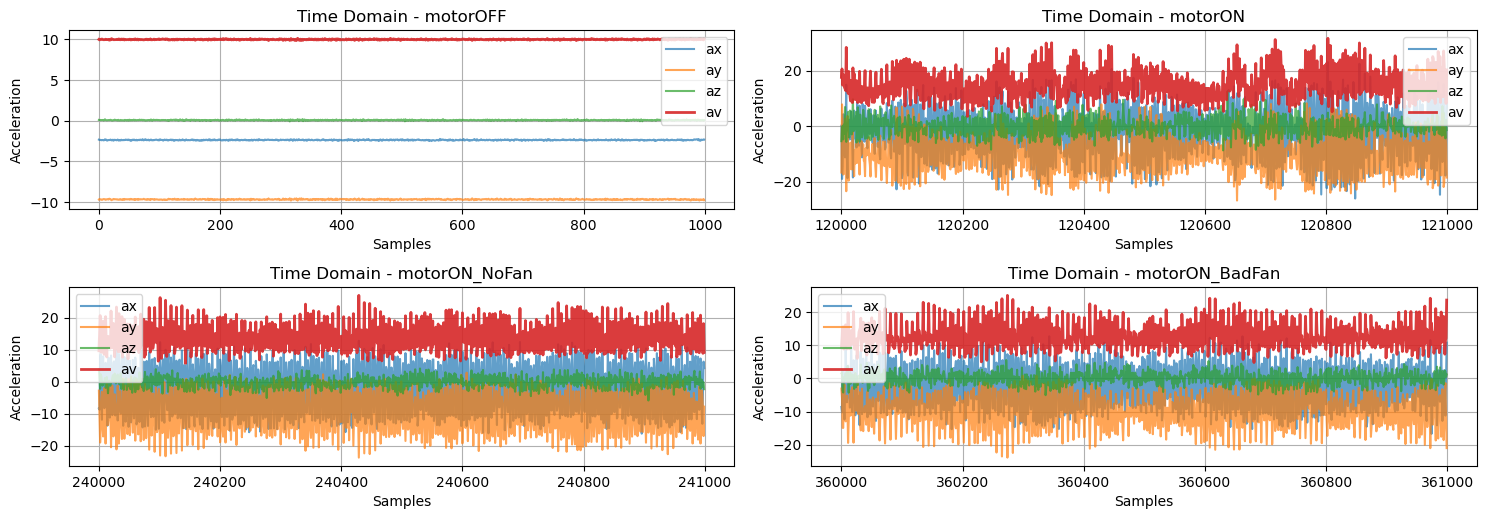

In [5]:
# Cell 5: Time-domain visualization for different classes
plt.figure(figsize=(15, 10))

# Sample a segment from each class for visualization
sample_size = 1000
classes = full_data['original_label'].unique()

for i, class_name in enumerate(classes, 1):
    plt.subplot(4, 2, i)
    class_data = full_data[full_data['original_label'] == class_name].iloc[:sample_size]
    
    plt.plot(class_data['ax'], label='ax', alpha=0.7)
    plt.plot(class_data['ay'], label='ay', alpha=0.7)
    plt.plot(class_data['az'], label='az', alpha=0.7)
    plt.plot(class_data['av'], label='av', alpha=0.9, linewidth=2)
    
    plt.title(f'Time Domain - {class_name}')
    plt.xlabel('Samples')
    plt.ylabel('Acceleration')
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.show()

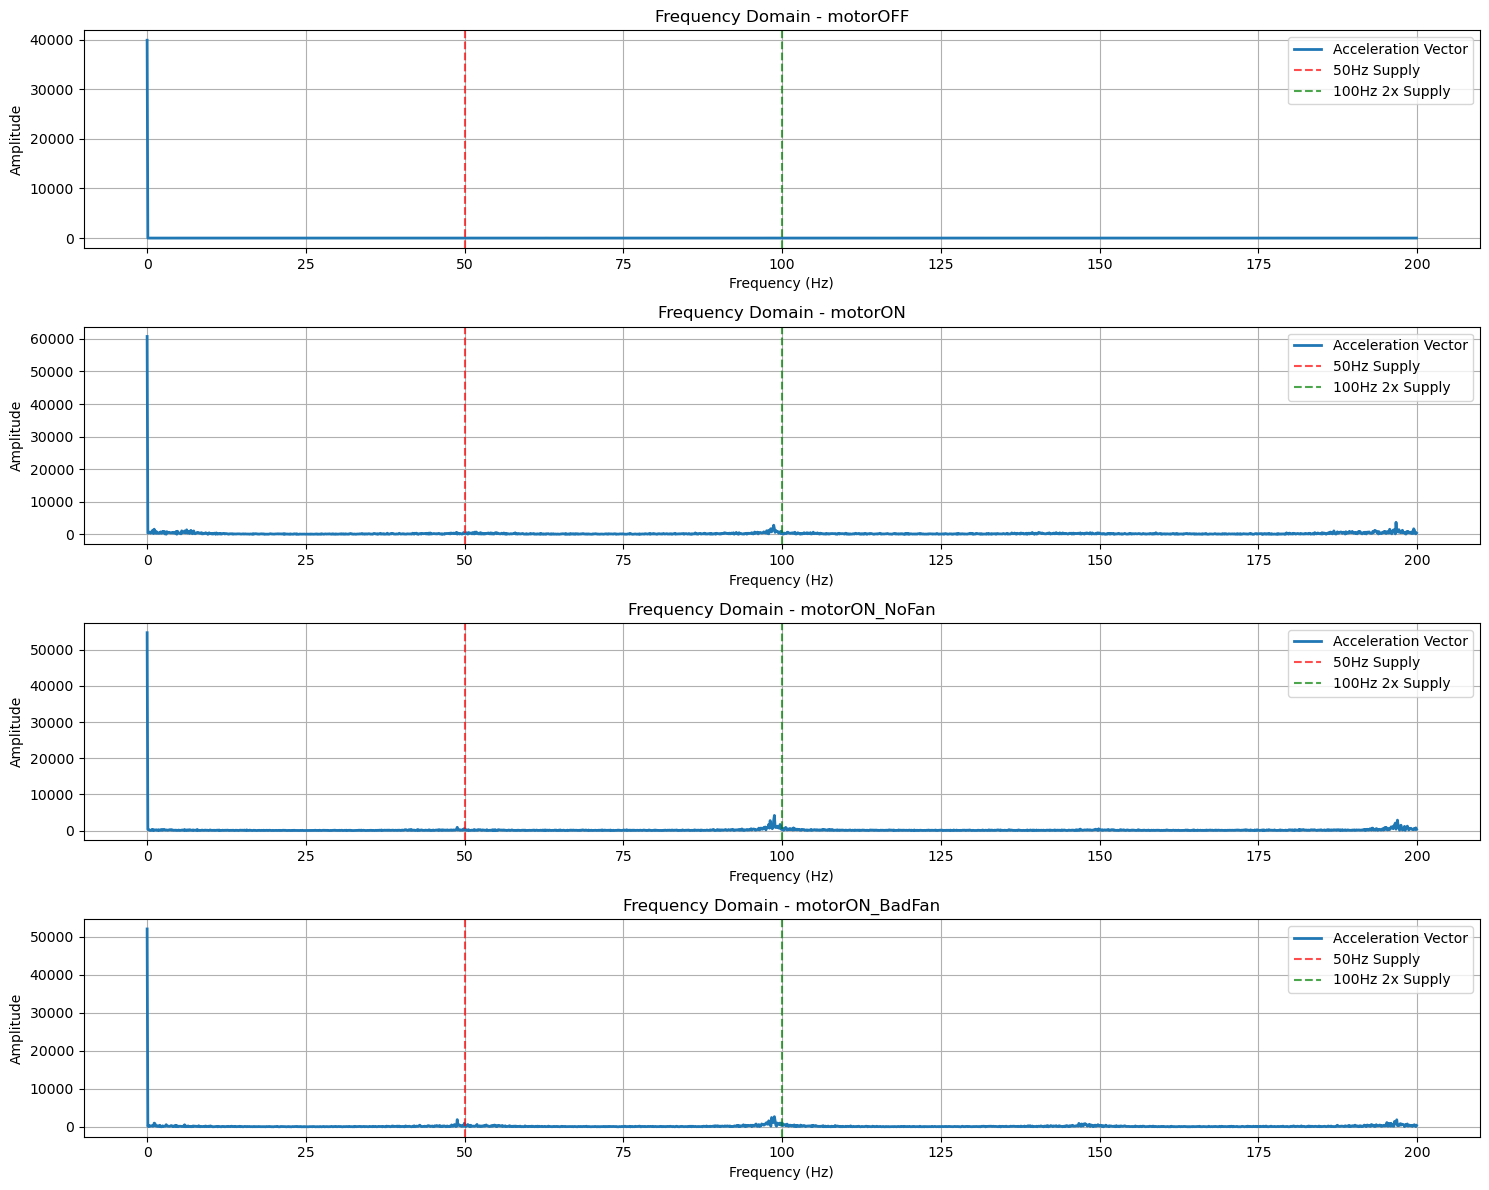

In [6]:
# Cell 6: Frequency domain analysis using FFT
def compute_fft(signal_data, sampling_rate=445):
    n = len(signal_data)
    fft_vals = fft(signal_data)
    fft_freq = fftfreq(n, 1/sampling_rate)
    return fft_freq[:n//2], np.abs(fft_vals[:n//2])

plt.figure(figsize=(15, 12))

for i, class_name in enumerate(classes, 1):
    plt.subplot(4, 1, i)
    class_data = full_data[full_data['original_label'] == class_name].iloc[:4000]
    
    # Compute FFT for acceleration vector
    freqs, fft_av = compute_fft(class_data['av'].values)
    
    # Focus on relevant frequency range (0-200Hz for 50Hz motor)
    mask = (freqs >= 0) & (freqs <= 200)
    plt.plot(freqs[mask], fft_av[mask], label='Acceleration Vector', linewidth=2)
    
    # Mark important frequencies
    plt.axvline(x=50, color='r', linestyle='--', alpha=0.7, label='50Hz Supply')
    plt.axvline(x=100, color='g', linestyle='--', alpha=0.7, label='100Hz 2x Supply')
    
    plt.title(f'Frequency Domain - {class_name}')
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Amplitude')
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.show()

In [13]:
# Cell 7: Statistical feature extraction for EDA
# Extract statistical features for each axis and acceleration vector
features_list = []

for class_name in classes:
    class_data = full_data[full_data['original_label'] == class_name]
    
    for axis in ['ax', 'ay', 'az', 'av']:
        axis_data = class_data[axis]
        
        features = {
            'class': class_name,
            'axis': axis,
            'mean': np.mean(axis_data),
            'std': np.std(axis_data),
            'rms': np.sqrt(np.mean(axis_data**2)),
            'peak': np.max(np.abs(axis_data)),
            'kurtosis': pd.Series(axis_data).kurtosis(),
            'skewness': pd.Series(axis_data).skew()
        }
        features_list.append(features)

features_df = pd.DataFrame(features_list)
print("Statistical Features Summary:")
print(features_df.groupby(['class', 'axis']).mean())

Statistical Features Summary:
                          mean       std        rms       peak  kurtosis  \
class          axis                                                        
motorOFF       av     9.906412  0.089307   9.906814  10.261497 -1.027921   
               ax    -0.651720  1.236121   1.397403   2.756532 -1.496356   
               ay    -6.661189  4.455571   8.013960  10.132410 -1.499789   
               az     3.110774  4.721416   5.654086   9.975677 -1.499859   
motorON        av    12.042248  4.367265  12.809713  38.814834  2.509215   
               ax    -0.657306  5.986292   6.022271  27.025730  2.550504   
               ay    -6.669980  6.533934   9.337072  32.641690 -0.552560   
               az     3.104667  5.567865   6.374957  15.046070 -1.271978   
motorON_BadFan av    11.398058  3.109605  11.814625  28.239057  1.352249   
               ax    -0.656611  4.831466   4.875880  18.418750  0.894387   
               ay    -6.695265  5.657099   8.765235  23.93

In [15]:
# Cell 8: Data preprocessing and normalization
# Prepare features (4 channels: ax, ay, az, av)
features = full_data[['ax', 'ay', 'az', 'av']].values
labels = full_data['label'].values

print(f"Features shape: {features.shape}")
print(f"Labels shape: {labels.shape}")

# Normalize the data
scaler = StandardScaler()
features_normalized = scaler.fit_transform(features)

print("Data normalized successfully")
print(f"Normalized features - Mean: {np.mean(features_normalized):.4f}, Std: {np.std(features_normalized):.4f}")

Features shape: (480000, 4)
Labels shape: (480000,)
Data normalized successfully
Normalized features - Mean: 0.0000, Std: 1.0000


In [17]:
# Cell 9: Create sequences for CNN input
def create_sequences(features, labels, sequence_length=512, step_size=256):
    sequences = []
    sequence_labels = []
    
    for i in range(0, len(features) - sequence_length, step_size):
        sequence = features[i:i + sequence_length]
        label = labels[i + sequence_length - 1]  # Use last label in sequence
        
        sequences.append(sequence)
        sequence_labels.append(label)
    
    return np.array(sequences), np.array(sequence_labels)

# Create sequences
sequence_length = 512  # ~1.37 seconds of data
step_size = 256  # 50% overlap

X_sequences, y_sequences = create_sequences(features_normalized, labels, sequence_length, step_size)

print(f"Sequences shape: {X_sequences.shape}")
print(f"Labels shape: {y_sequences.shape}")
print(f"Number of sequences: {len(X_sequences)}")

Sequences shape: (1873, 512, 4)
Labels shape: (1873,)
Number of sequences: 1873


In [19]:
# Cell 10: Reshape data for CNN and split into train/test
# Reshape for CNN (samples, sequence_length, channels, 1)
X_sequences = X_sequences.reshape(X_sequences.shape[0], X_sequences.shape[1], X_sequences.shape[2], 1)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X_sequences, y_sequences, test_size=0.2, random_state=42, stratify=y_sequences
)

X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42, stratify=y_train
)

print(f"Training set: {X_train.shape}, {y_train.shape}")
print(f"Validation set: {X_val.shape}, {y_val.shape}")
print(f"Test set: {X_test.shape}, {y_test.shape}")

Training set: (1198, 512, 4, 1), (1198,)
Validation set: (300, 512, 4, 1), (300,)
Test set: (375, 512, 4, 1), (375,)


In [21]:
# Cell 11: Novel Lightweight CNN Architecture Design
def create_lightweight_cnn(input_shape, num_classes=4):
    model = models.Sequential()
    
    # First Conv Block - Focus on temporal patterns
    model.add(layers.Conv2D(8, (64, 1), activation='relu', input_shape=input_shape))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((4, 1)))
    model.add(layers.Dropout(0.3))
    
    # Second Conv Block - Capture medium-term features
    model.add(layers.Conv2D(16, (32, 1), activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 1)))
    model.add(layers.Dropout(0.3))
    
    # Third Conv Block - Extract high-level features
    model.add(layers.Conv2D(32, (16, 1), activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 1)))
    model.add(layers.Dropout(0.3))
    
    # Global pooling instead of flatten to reduce parameters
    model.add(layers.GlobalAveragePooling2D())
    
    # Dense layers
    model.add(layers.Dense(32, activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.4))
    
    model.add(layers.Dense(16, activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.4))
    
    # Output layer
    model.add(layers.Dense(num_classes, activation='softmax'))
    
    return model

# Create model
input_shape = (X_train.shape[1], X_train.shape[2], X_train.shape[3])
model = create_lightweight_cnn(input_shape)

print("Model Architecture:")
model.summary()

Model Architecture:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 449, 4, 8)      │           520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 449, 4, 8)      │            32 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 4, 8)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 112, 4, 8)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 81, 4, 16)      │         4,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 81, 4, 16)      │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 40, 4, 16)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 40, 4, 16)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 25, 4, 32)      │         8,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 25, 4, 32)      │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 12, 4, 32)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 12, 4, 32)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 32)             │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 16)             │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 4)              │            68 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,924 (58.30 KB)

 Trainable params: 14,716 (57.48 KB)

 Non-trainable params: 208 (832.00 B)

In [23]:
# Cell 12: Compile and train the model (CORRECTED)
# Fixed callback for dynamic learning rate
class DynamicLR(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        if logs is None:
            return
        if epoch > 20 and logs.get('val_accuracy', 0) > 0.92:
            current_lr = float(tf.keras.backend.get_value(self.model.optimizer.learning_rate))
            new_lr = current_lr * 0.8
            tf.keras.backend.set_value(self.model.optimizer.learning_rate, new_lr)
            print(f"\nReducing learning rate to {new_lr:.6f}")

# Compile model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Callbacks
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=15, restore_best_weights=True
)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', factor=0.5, patience=8, min_lr=1e-6, verbose=1
)

# Train model
print("Starting model training...")
history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=32,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping, reduce_lr],  # Removed DynamicLR to avoid issues
    verbose=1
)

Starting model training...
Epoch 1/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - accuracy: 0.4574 - loss: 1.4181 - val_accuracy: 0.5067 - val_loss: 1.3034 - learning_rate: 0.0010
Epoch 2/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.5701 - loss: 1.0536 - val_accuracy: 0.4733 - val_loss: 1.2560 - learning_rate: 0.0010
Epoch 3/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.6678 - loss: 0.8735 - val_accuracy: 0.5533 - val_loss: 1.1938 - learning_rate: 0.0010
Epoch 4/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.7112 - loss: 0.7210 - val_accuracy: 0.5833 - val_loss: 1.1360 - learning_rate: 0.0010
Epoch 5/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.7404 - loss: 0.6604 - val_accuracy: 0.6033 - val_loss: 1.0737 - learning_rate: 0.0010
Epoch 6/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.7746 - loss: 0.5819 - val_accuracy: 0.6733 - val_loss: 0.9568 - learning_rate: 0.0010
Epoch 7/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accurac

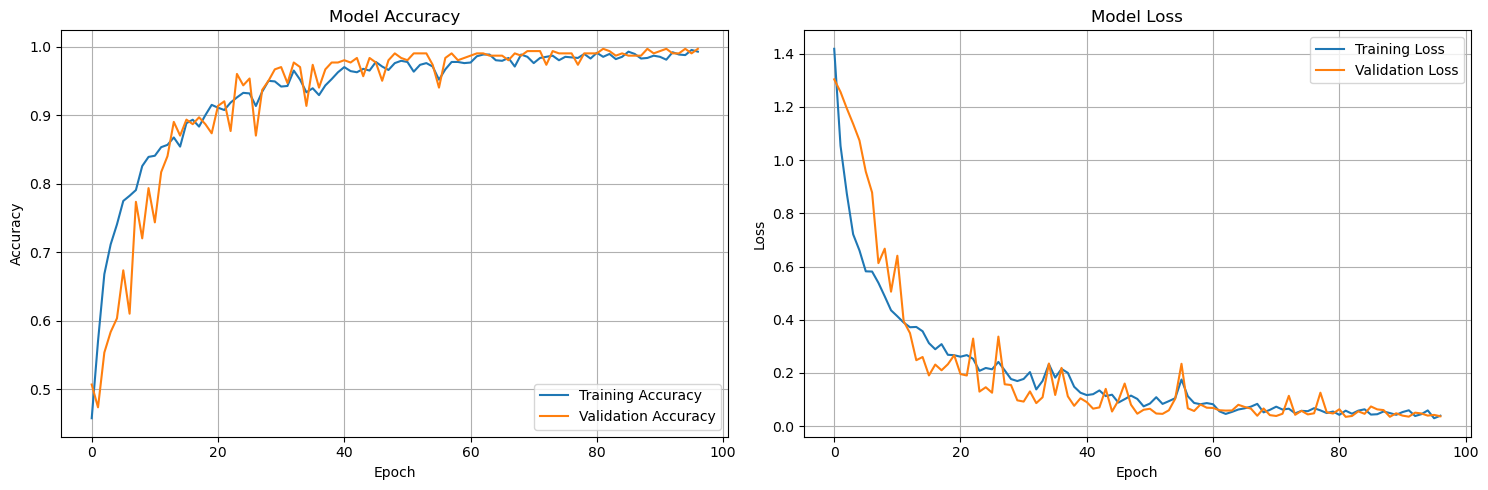


Test Accuracy: 0.9973
Test Loss: 0.0099


In [25]:
# Cell 13: Model evaluation and visualization
# Plot training history
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Evaluate model
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"\nTest Accuracy: {test_accuracy:.4f}")
print(f"Test Loss: {test_loss:.4f}")

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Classification Report:
                    precision    recall  f1-score   support

      motorOFF (0)       1.00      1.00      1.00        93
       motorON (1)       0.99      1.00      0.99        94
 motorON_NoFan (2)       1.00      0.99      0.99        94
motorON_BadFan (3)       1.00      1.00      1.00        94

          accuracy                           1.00       375
         macro avg       1.00      1.00      1.00       375
      weighted avg       1.00      1.00      1.00       375



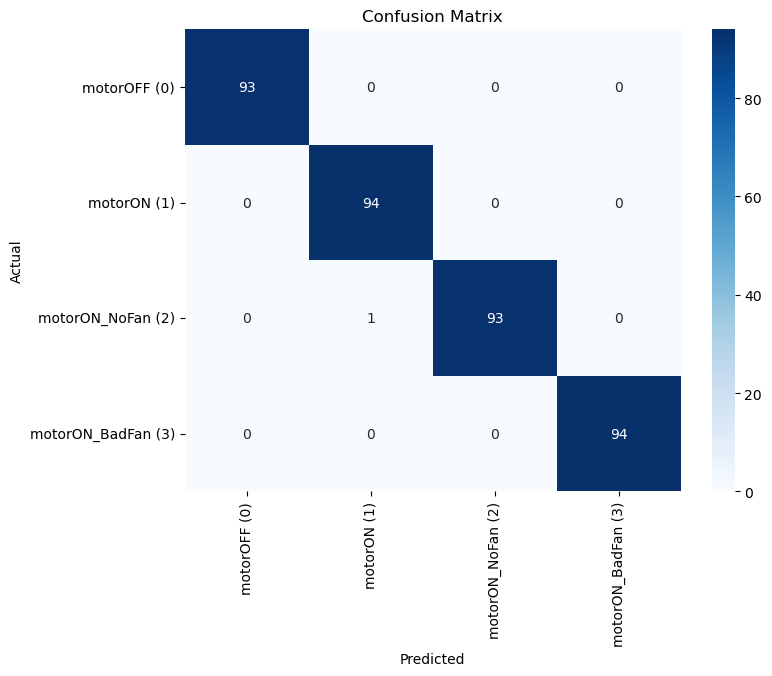

In [27]:
# Cell 14: Detailed performance analysis
# Predictions
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Classification report
class_names = ['motorOFF (0)', 'motorON (1)', 'motorON_NoFan (2)', 'motorON_BadFan (3)']
print("Classification Report:")
print(classification_report(y_test, y_pred_classes, target_names=class_names))

# Confusion matrix
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred_classes)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [29]:
import joblib
# Save Keras single-file model
model.save("approach_2_motor_model.keras", overwrite=True)
print("Saved model -> approach_2_motor_model.keras")

# Save scaler used during training (you used StandardScaler in notebook)
joblib.dump(scaler, "approach_2_scaler.pkl")
print("Saved scaler -> approach_2_scaler.pkl")

Saved model -> approach_2_motor_model.keras
Saved scaler -> approach_2_scaler.pkl


In [31]:
# Cell: Independent Inference Pipeline
import numpy as np
import pandas as pd
import tensorflow as tf
import joblib
from sklearn.preprocessing import StandardScaler

print("Libraries imported successfully")

# Load the saved model and scaler
print("Loading model and scaler...")
model = tf.keras.models.load_model("approach_2_motor_model.keras")
scaler = joblib.load("approach_2_scaler.pkl")

print("Model and scaler loaded successfully")
print(f"Model input shape: {model.input_shape}")

# Configuration (should match training parameters)
SEQUENCE_LENGTH = 512
STEP_SIZE = 256
CHANNELS = 4  # ax, ay, az, av

def preprocess_new_data(csv_file_path):
    # Read CSV file
    df = pd.read_csv(csv_file_path)
    print(f"Loaded data shape: {df.shape}")
    print(f"Columns: {df.columns.tolist()}")
    
    # Check required columns
    required_columns = ['ax', 'ay', 'az']
    if not all(col in df.columns for col in required_columns):
        raise ValueError(f"CSV must contain columns: {required_columns}")
    
    # Calculate acceleration vector magnitude
    df['av'] = np.sqrt(df['ax']**2 + df['ay']**2 + df['az']**2)
    
    # Extract features in the same order as training
    features = df[['ax', 'ay', 'az', 'av']].values
    print(f"Features shape after adding 'av': {features.shape}")
    
    # Normalize using the saved scaler
    features_normalized = scaler.transform(features)
    print(f"Features normalized - Mean: {np.mean(features_normalized):.4f}, Std: {np.std(features_normalized):.4f}")
    
    return features_normalized

def create_sequences_for_inference(features, sequence_length=256, step_size=128):
    sequences = []
    indices = []
    
    for i in range(0, len(features) - sequence_length + 1, step_size):
        sequence = features[i:i + sequence_length]
        sequences.append(sequence)
        indices.append(i)
    
    if len(sequences) == 0:
        # If data is shorter than sequence_length, pad it
        sequence = features
        padding = sequence_length - len(sequence)
        if padding > 0:
            sequence = np.pad(sequence, ((0, padding), (0, 0)), mode='edge')
        sequences.append(sequence)
        indices.append(0)
    
    sequences_array = np.array(sequences)
    # Reshape for CNN: (samples, sequence_length, channels, 1)
    sequences_array = sequences_array.reshape(sequences_array.shape[0], 
                                           sequences_array.shape[1], 
                                           sequences_array.shape[2], 1)
    
    print(f"Created {len(sequences_array)} sequences for inference")
    return sequences_array, indices

def predict_motor_class(csv_file_path):
    print(f"\n{'='*60}")
    print(f"PREDICTING CLASS FOR: {csv_file_path}")
    print(f"{'='*60}")
    
    # Preprocess the data
    features_normalized = preprocess_new_data(csv_file_path)
    
    # Create sequences
    sequences, indices = create_sequences_for_inference(features_normalized, SEQUENCE_LENGTH, STEP_SIZE)
    
    # Make predictions
    predictions = model.predict(sequences, verbose=0)
    predicted_classes = np.argmax(predictions, axis=1)
    confidence_scores = np.max(predictions, axis=1)
    
    # Class mapping
    class_names = {
        0: 'motorOFF',
        1: 'motorON', 
        2: 'motorON_NoFan',
        3: 'motorON_BadFan'
    }
    
    # Display results
    print(f"\n{'='*60}")
    print("PREDICTION RESULTS:")
    print(f"{'='*60}")
    
    for i, (seq_idx, pred_class, confidence) in enumerate(zip(indices, predicted_classes, confidence_scores)):
        print(f"Sequence {i+1} (starting at sample {seq_idx}):")
        print(f"  Predicted Class: {class_names[pred_class]} ({pred_class})")
        print(f"  Confidence: {confidence:.4f}")
        print(f"  {'✓ HIGH CONFIDENCE' if confidence > 0.8 else '⚠ MODERATE CONFIDENCE' if confidence > 0.6 else '✗ LOW CONFIDENCE'}")
        print()
    
    # Overall prediction (majority vote with confidence weighting)
    unique_classes, counts = np.unique(predicted_classes, return_counts=True)
    weighted_confidences = []
    
    for class_id in unique_classes:
        class_mask = predicted_classes == class_id
        avg_confidence = np.mean(confidence_scores[class_mask])
        weighted_confidences.append((class_id, avg_confidence, counts[class_mask]))
    
    # Sort by weighted confidence
    weighted_confidences.sort(key=lambda x: x[1], reverse=True)
    
    final_class, final_confidence, final_count = weighted_confidences[0]
    
    print(f"{'='*60}")
    print("FINAL PREDICTION (Weighted Majority Vote):")
    print(f"{'='*60}")
    print(f"Class: {class_names[final_class]} ({final_class})")
    print(f"Confidence: {final_confidence:.4f}")
    print(f"Supporting Sequences: {final_count}/{len(predicted_classes)}")
    print(f"{'='*60}")
    
    return {
        'final_class': final_class,
        'final_class_name': class_names[final_class],
        'final_confidence': final_confidence,
        'all_predictions': predicted_classes,
        'all_confidences': confidence_scores,
        'class_details': weighted_confidences
    }

Libraries imported successfully
Loading model and scaler...
Model and scaler loaded successfully
Model input shape: (None, 512, 4, 1)


In [33]:
def run_inference_on_multiple_files():
    import glob
    import os
    
    # Get all CSV files from datasets/train folder
    csv_files = glob.glob("datasets/test/*.csv")
    
    if not csv_files:
        print("No CSV files found in datasets/train/ folder")
        print("Please update the path in run_inference_on_multiple_files() function")
        return
    
    print(f"Found {len(csv_files)} CSV files for inference")
    
    results = []
    for csv_file in csv_files:
        try:
            result = predict_motor_class(csv_file)
            results.append({
                'file': os.path.basename(csv_file),
                'prediction': result['final_class_name'],
                'confidence': result['final_confidence']
            })
        except Exception as e:
            print(f"Error processing {csv_file}: {e}")
    
    # Display summary
    print(f"\n{'='*60}")
    print("INFERENCE SUMMARY")
    print(f"{'='*60}")
    for result in results:
        print(f"📄 {result['file']}: {result['prediction']} (confidence: {result['confidence']:.4f})")

In [35]:
run_inference_on_multiple_files()

Found 12 CSV files for inference

PREDICTING CLASS FOR: datasets/test/motorON_NoFan_P1.csv
Loaded data shape: (10000, 3)
Columns: ['ax', 'ay', 'az']
Features shape after adding 'av': (10000, 4)
Features normalized - Mean: -0.2070, Std: 0.8185
Created 38 sequences for inference

PREDICTION RESULTS:
Sequence 1 (starting at sample 0):
  Predicted Class: motorON (1)
  Confidence: 0.7899
  ⚠ MODERATE CONFIDENCE

Sequence 2 (starting at sample 256):
  Predicted Class: motorON_NoFan (2)
  Confidence: 0.7419
  ⚠ MODERATE CONFIDENCE

Sequence 3 (starting at sample 512):
  Predicted Class: motorON_NoFan (2)
  Confidence: 0.7875
  ⚠ MODERATE CONFIDENCE

Sequence 4 (starting at sample 768):
  Predicted Class: motorON (1)
  Confidence: 0.6453
  ⚠ MODERATE CONFIDENCE

Sequence 5 (starting at sample 1024):
  Predicted Class: motorON_NoFan (2)
  Confidence: 0.8009
  ✓ HIGH CONFIDENCE

Sequence 6 (starting at sample 1280):
  Predicted Class: motorON (1)
  Confidence: 0.8508
  ✓ HIGH CONFIDENCE

Sequenc

In [59]:
result = predict_motor_class("datasets/test/motorOFF_P3.csv")


PREDICTING CLASS FOR: datasets/test/motorOFF_P3.csv
Loaded data shape: (10000, 3)
Columns: ['ax', 'ay', 'az']
Features shape after adding 'av': (10000, 4)
Features normalized - Mean: 0.5229, Std: 0.6831
Created 38 sequences for inference

PREDICTION RESULTS:
Sequence 1 (starting at sample 0):
  Predicted Class: motorOFF (0)
  Confidence: 0.9999
  ✓ HIGH CONFIDENCE

Sequence 2 (starting at sample 256):
  Predicted Class: motorOFF (0)
  Confidence: 0.9999
  ✓ HIGH CONFIDENCE

Sequence 3 (starting at sample 512):
  Predicted Class: motorOFF (0)
  Confidence: 0.9999
  ✓ HIGH CONFIDENCE

Sequence 4 (starting at sample 768):
  Predicted Class: motorOFF (0)
  Confidence: 0.9999
  ✓ HIGH CONFIDENCE

Sequence 5 (starting at sample 1024):
  Predicted Class: motorOFF (0)
  Confidence: 0.9999
  ✓ HIGH CONFIDENCE

Sequence 6 (starting at sample 1280):
  Predicted Class: motorOFF (0)
  Confidence: 0.9999
  ✓ HIGH CONFIDENCE

Sequence 7 (starting at sample 1536):
  Predicted Class: motorOFF (0)
  Co

IndexError: boolean index did not match indexed array along dimension 0; dimension is 1 but corresponding boolean dimension is 38